# Demo: Raster fundamentals, Rasterio, Band Math with Arrays
UW Geospatial Data Analysis  
CEE467/CEWA567  
David Shean  

## Introduction
See reading assignment [05_Raster1_GDAL_rasterio_LS8_prep](./05_Raster1_GDAL_rasterio_LS8_prep.md)

## What is a raster?

## Raster data sources
* Satellite imagery
* Gridded model output
* Interpolated vector data

## Raster fundamentals
Interactive discussion during demo

### Dimensions (width [columns] and height [rows] in pixels)
### CRS (coordinate system)
### Extent (bounds)
### Resolution (pixel size)
### Data type (bit depth)
### Number of bands
### NoData values

## GDAL (Geospatial Data Abstraction Library) and Rasterio
GDAL is a powerful and mature library for reading, writing and warping raster datasets, written in C++ with bindings to other languages. There are a variety of geospatial libraries available on the python package index, and almost all of them depend on GDAL. One such python library developed and supported by Mapbox, rasterio, builds on top of GDAL’s many features, but provides a more pythonic interface and supports many of the features and formats that GDAL supports. Both GDAL and rasterio are constantly being updated and improved.

## Raster formats
* GeoTiff is most common
* GDAL is the foundation - drivers for hundreds of formats

## CRS and Projections
* Most often UTM
* PROJ is the foundation (as with GeoPandas)

## Raster transformations

### Sensor to orthorectified raster image
* Consider the simple example of a 2D detector in a simple camera (e.g., Planet Dove)
* Takes a "snapshot" of the Earth surface
* A "camera model" or "sensor model" allows you to relate each pixel in the 2D image acquired by the detector to corresponding geographic locations on the ground
* Can then create an orthorectified image in some projected coordinate system (like Google Satellite basemap) using a DEM - corrects for perspective, terrain variations
* The orthoimage is still a 2D image on the disk, with different number of rows and columns than the original 2D image in sensor coordinates
* now "georeferenced" with metadata for the map coordiantes of the upper left pixel and the ground sample distance of each pixel

### Orthorectified raster image to projected map coordinates (where we start with Landsat L2 products)
* Need a way to go from pixel coordinates (2D rectangular image on your screen) to real-world coordinates (projected)
    * Image pixel coordinate system: image width, height in units of pixels, origin (0,0) in upper left corner
    * Projected coordinate system: "real-world" coordinate system (e.g., UTM 10N) with units of meters and origin (0,0) defined by the CRS (e.g., equator and prime meridian)
* Origin is usually upper left corner of upper left pixel
    * Careful about this - you will definitely run into this problem at some point
    * Some raster datasets may be shifted by a half a pixel in x and y - *upper left corner* of upper left pixel vs. *center* of upper left pixel
* Negative y cell size - what's up with that?
    * Historical system used by early displays: https://en.wikipedia.org/wiki/Raster_scan

### rasterio affine
* Multiply affine by raster (row, col) values to get projected coordinates
* Rasterio dataset `xy` and `index` methods

### GDAL/ESRI affine

## Basic raster structure
* Dataset object
    * Open to access metadata, doesn't read pixels
* Bands
    * Often just 1 band, sometimes multiple bands in a single Dataset (new axis)
* Can read individual bands to access corresponding 2D array data
    * Handling missing data (nodata) - masked arrays vs. np.nan

### Overviews

## 3D array to create composites from multispectral bands
* Can dstack 2D arrays
* Will revisit with `rioxarray`

## Misc
* Be careful with large rasters, esp float - don't load into memory
* Read in a window or every nth pixel when prototyping. Only read in full res when code is working for smaller raster.
* Try to avoid creating many copies of arrays, close datasets no longer needed

## GDAL command line utilities

* https://gdal.org/programs/index.html
* Most common tools to learn:
    * gdalinfo
    * gdal_translate
    * gdalwarp
    * gdaladdo
* Items to discuss
    * Use standard creation options (co)
        * TILED=YES
        * COMPRESS=LZW
        * BIGTIFF=IF_SAFER
    * Resampling algorithms
        * Default is nearest
        * Often bilinear or bicubic is a better choice for reprojecting, upsampling, downsampling

https://medium.com/planet-stories/a-gentle-introduction-to-gdal-part-4-working-with-satellite-data-d3835b5e2971

# Demo

https://automating-gis-processes.github.io/site/notebooks/Raster/reading-raster.html

In [ ]:
pwd

'/home/jovyan/jupyterbook/book/modules/05_Raster1_GDAL_rasterio_LS8'

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import rasterio as rio
import rasterio.plot
from osgeo import gdal

#Useful package to add dynamic scalebar to matplotlib images
from matplotlib_scalebar.scalebar import ScaleBar

In [ ]:
#We want to use interactive plotting for zoom/pan and live coordinate display
#%matplotlib widget
%matplotlib inline

In [ ]:
#Create local directory to store images
imgdir = 'LS8_sample'

#Pre-identified cloud-free Image IDs used for the lab
#Summer 2018
img_id1 = 'LC08_L2SP_046027_20180818_20200831_02_T1'
#Winter 2018
img_id2 = 'LC08_L2SP_046027_20181224_20200829_02_T1'

img = img_id1

## Let's use the Thermal IR band for this demo

In [ ]:
#Specify filenames for different bands we will need for the lab
#Check table from background section to see wavelengths of each band number
tir_fn = os.path.join(imgdir, img+'_ST_B10.TIF')
print(tir_fn)

LS8_sample/LC08_L2SP_046027_20180818_20200831_02_T1_ST_B10.TIF


In [ ]:
!gdalinfo $tir_fn

Driver: GTiff/GeoTIFF
Files: LS8_sample/LC08_L2SP_046027_20180818_20200831_02_T1_ST_B10.TIF
Size is 7771, 7891
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 10N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 10N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-123,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metr

# Rasterio basics
* We'll stick with rasterio for most of our Python raster analysis 
* https://rasterio.readthedocs.io/en/stable/quickstart.html

## Use a Python `with` construct to cleanly open, inspect, and close the file directly from the url
* The Python `with` construct may be new, or maybe you used it during Lab02 when opening a text file for reading/writing.
* It is "used in exception handling to make the code cleaner and much more readable. It simplifies the management of common resources like file streams."
    * Enables more elegant file opening/closing and handling errors (like missing files)
* Let's use the `with rio.open()` approach to print out the rasterio dataset profile, without actually reading the underlying image data
    * We will temporarily store the rasterio dataset with variable name `src` (short for "source")

In [ ]:
with rio.open(tir_fn) as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 7771, 'height': 7891, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(30.0, 0.0, 473685.0,
       0.0, -30.0, 5373615.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


## Can also open dataset with rasterio for persistence and interactive access
* This is likely a better option as you're learning, as you can access the opened dataset and arrays you've already read in other cells
* Remember to close the rasterio dataset when no longer needed!

In [ ]:
src = rio.open(tir_fn)

In [ ]:
type(src)

rasterio.io.DatasetReader

In [ ]:
src.profile

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 7771, 'height': 7891, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(30.0, 0.0, 473685.0,
       0.0, -30.0, 5373615.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

In [ ]:
src.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0.0,
 'width': 7771,
 'height': 7891,
 'count': 1,
 'crs': CRS.from_epsg(32610),
 'transform': Affine(30.0, 0.0, 473685.0,
        0.0, -30.0, 5373615.0)}

In [ ]:
src.crs

CRS.from_epsg(32610)

### Plot using rasterio `show()` function
* Note axes tick labels

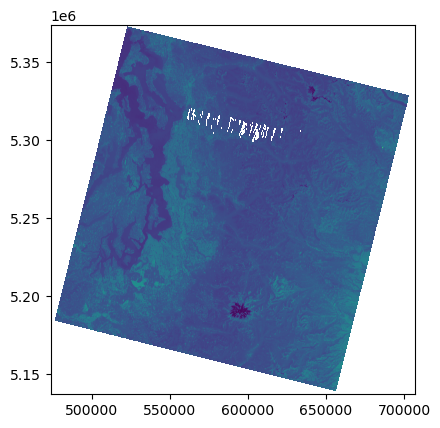

In [ ]:
rio.plot.show(src);

### Read the array

In [ ]:
#src.read?

In [ ]:
#Note memory usage before and after reading
%time
a = src.read(1)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 7.63 µs


In [ ]:
a

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [ ]:
a.shape

(7891, 7771)

### Plot using Matplotlib `imshow`
* Note axes tick labels

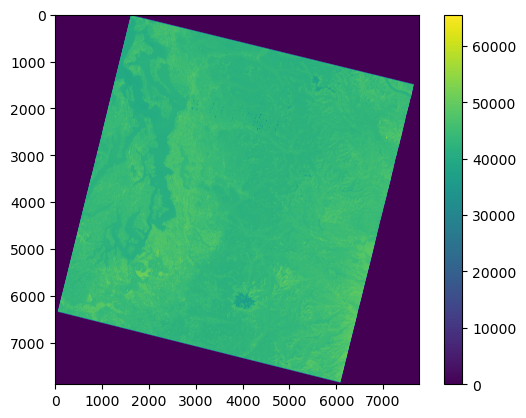

In [ ]:
f,ax = plt.subplots()
m = ax.imshow(a)
plt.colorbar(m, ax=ax);

## Inspect the array

In [ ]:
a.shape

(7891, 7771)

In [ ]:
a.size

61320961

In [ ]:
a.dtype

dtype('uint16')

In [ ]:
a.min()

0

In [ ]:
a.max()

65535

In [ ]:
2**16

65536

In [ ]:
a.shape

(7891, 7771)

In [ ]:
#Convert to 1D (needed for histogram)
a.ravel().shape

(61320961,)

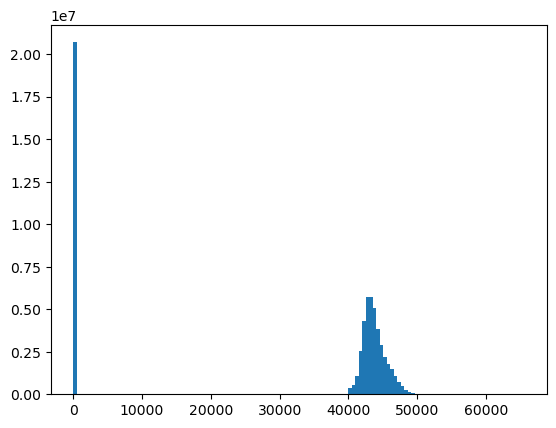

In [ ]:
f, ax = plt.subplots()
ax.hist(a.ravel(), bins=128);

## Data type and bit depth
* Note values in histogram - 16 bit integer vs. 12 bit dynamic range of instrument

In [ ]:
2**16

65536

In [ ]:
#Landsat-8 OLI is 12-bit sensor
2**12

4096

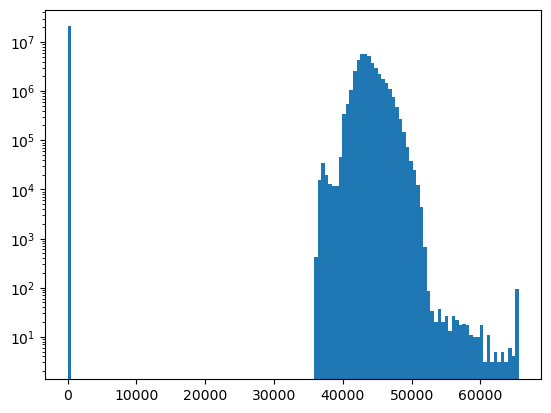

In [ ]:
f, ax = plt.subplots()
ax.hist(a.ravel(), bins=128, log=True);

## Use a masked array to handle nodata

In [ ]:
src.profile

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 7771, 'height': 7891, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(30.0, 0.0, 473685.0,
       0.0, -30.0, 5373615.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

In [ ]:
src.nodata

0.0

In [ ]:
src.nodatavals

(0.0,)

In [ ]:
#If nodata is defined, rasterio can created masked array when reading
src.read(1, masked=True)

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0,
  dtype=uint16)

In [ ]:
#Can also create from existing NumPy array
#np.ma.masked_equal?

In [ ]:
np.ma.masked_equal(a, 0)

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0,
  dtype=uint16)

In [ ]:
a = np.ma.masked_equal(a, 0)

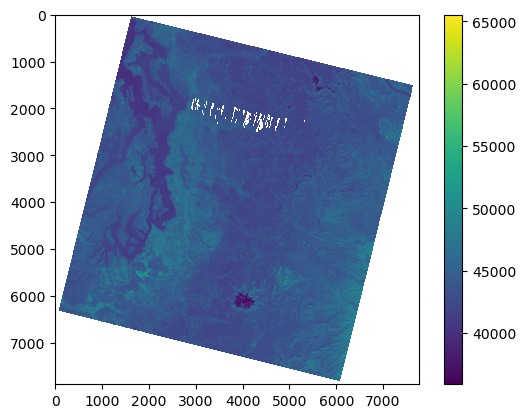

In [ ]:
f,ax = plt.subplots()
m = ax.imshow(a)
plt.colorbar(m, ax=ax);

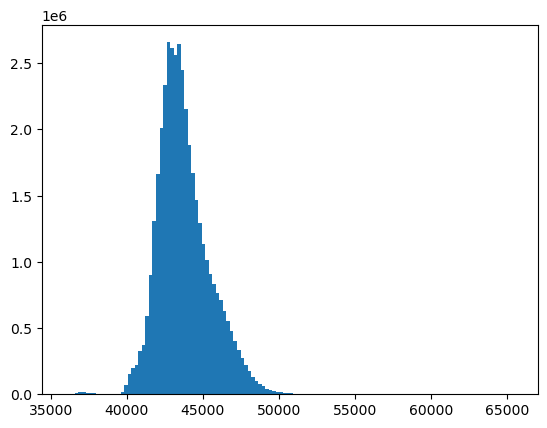

In [ ]:
f, ax = plt.subplots()
ax.hist(a.compressed(), bins=128);

## Scaling 16-bit values to geophysical variables - surface reflectance and temperature
* Use raster math to multiply by scaling factor and add offset value
* See conversion factors here: https://www.usgs.gov/landsat-missions/landsat-collection-2-level-2-science-products
* https://www.usgs.gov/faqs/how-do-i-use-scale-factor-landsat-level-2-science-products
* Units:
    * Unitless surface reflectance values from 0.0 to 1.0
    * Surface temperature values in Kelvin - can convert to Celsius

In [ ]:
#Notes on attemting to apply scale and offset dynamically
#mode='r+', scales=(st_scale,), offsets=(st_offset,), mask_and_scale=True
#src.scales = (st_scale,)
#src.offsets = (st_offset,)
#src.scales, src.offsets

In [ ]:
#These are the standard scale and offset values
#SR 0.0000275 + -0.2
sr_scale = 0.0000275
sr_offset = -0.2
#ST 0.00341802 + 149.0
st_scale = 0.00341802
st_offset = 149.0

In [ ]:
#We are working with Thermal IR band, so let's use the thermal scale and offset
a_st = a * st_scale + st_offset

In [ ]:
#Convert to Celsius
a_st -= 273.15

In [ ]:
a_st.dtype

dtype('float64')

In [ ]:
a_st.min()

-1.4294099200000119

In [ ]:
#Float16 should provide enough precision for these data
a_st = a_st.astype('float32')

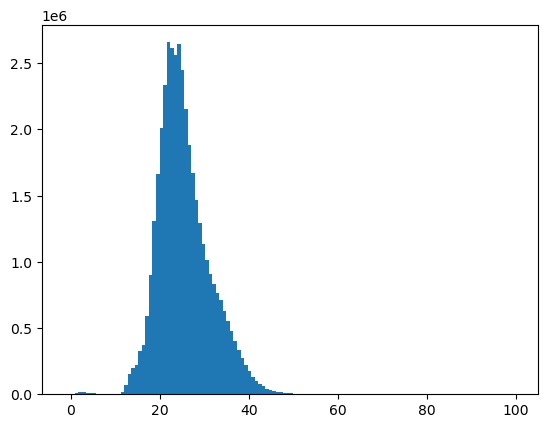

In [ ]:
f, ax = plt.subplots()
plt.hist(a_st.compressed(), bins=128);

In [ ]:
#%matplotlib widget

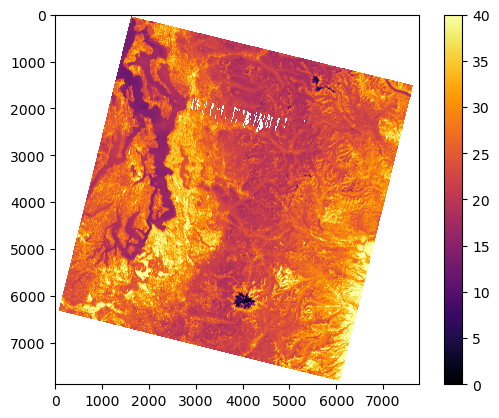

In [ ]:
f, ax = plt.subplots()
m = ax.imshow(a_st, vmin=0, vmax=40, cmap='inferno')
plt.colorbar(m, ax=ax);

### Bounds and extent

In [ ]:
#This is rasterio bounds object in projected units (meters) - note labels like dictionary keys and values
src.bounds

BoundingBox(left=473685.0, bottom=5136885.0, right=706815.0, top=5373615.0)

In [ ]:
#This is matplotlib extent
full_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
print(full_extent)

[473685.0, 706815.0, 5136885.0, 5373615.0]


In [ ]:
#rasterio convenience function
full_extent = rio.plot.plotting_extent(src)
print(full_extent)

(473685.0, 706815.0, 5136885.0, 5373615.0)


### Plot the image with matplotlib `imshow`, but now pass in this `extent` as an argument
* Note how the axes coordinates change
    * These should now be meters in the UTM 10N coordinate system of the projected image!

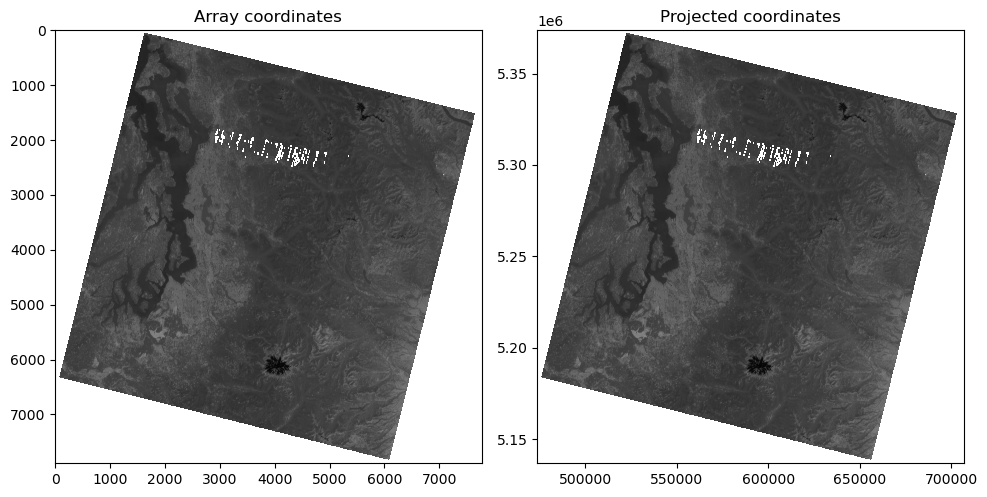

In [ ]:
f, axa = plt.subplots(1,2, figsize=(10,6))
axa[0].imshow(a, cmap='gray') #vmin=0, vmax=1
axa[0].set_title("Array coordinates")
axa[1].imshow(a, extent=full_extent, cmap='gray') #vmin=0, vmax=1
axa[1].set_title("Projected coordinates")
plt.tight_layout()

## Raster transform
* How does rasterio know the bounds?
* Inspect the dataset `transform` attribute
* You may have encountered an ESRI "world file" or GDAL geotransform before. This is the same idea, but Rasterio's model uses traditional affine transform.
* Review this: https://rasterio.readthedocs.io/en/stable/topics/georeferencing.html?highlight=affine#coordinate-transformation

In [ ]:
src.transform

Affine(30.0, 0.0, 473685.0,
       0.0, -30.0, 5373615.0)

In [ ]:
#These are (x,y) for corners in image/array coordinates (pixels)
#A bit confusing due to (row,col) of shape, which is (y,x)

#Upper left
ul = (0, 0)
#One pixel from upper left
ul1 = (1,1)
#Lower right
lr = (a_st.shape[1], a_st.shape[0])

print(ul, ul1, lr)

(0, 0) (1, 1) (7771, 7891)


In [ ]:
#Transform upper left corner to projected coordinates (meters)
print(ul)
ul_proj = src.transform * ul
print(ul_proj)

(0, 0)
(473685.0, 5373615.0)


In [ ]:
#Transform the one pixel offset from ul to projected coordinates (meters)
print(ul1)
ul1_proj = src.transform * ul1
print(ul1_proj)

(1, 1)
(473715.0, 5373585.0)


In [ ]:
np.array(ul_proj) - np.array(ul1_proj)

array([-30.,  30.])

In [ ]:
#Transform lower right corner
print(lr)
lr_proj = src.transform * lr
print(lr_proj)

(7771, 7891)
(706815.0, 5136885.0)


In [ ]:
wh_km = np.abs(np.array(ul_proj) - np.array(lr_proj))/1000
wh_km
print('Total width: %0.2f km\nTotal height: %0.2f km' % (wh_km[0], wh_km[1]))

Total width: 233.13 km
Total height: 236.73 km


## Raster and array sampling
* Use helper functions `xy` and `sample`

In [ ]:
a_st

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0.0,
  dtype=float32)

In [ ]:
a_st[0,0]

masked

In [ ]:
#Array coordinates
c = (3512, 3512)

In [ ]:
#Get value at coordinates using array indexing
a_st[c[0], c[1]]

23.241858

In [ ]:
#src.xy?

In [ ]:
#Note use of argument expansion here (*c) so we don't have to pass individual c[0] and c[1] values
x,y = src.xy(*c)
print(x,y)

579060.0 5268240.0


In [ ]:
#a_st[int(x), int(y)]

In [ ]:
#src.sample?

In [ ]:
#Doesn't actually produce coordinates
src.sample(x, y)

<generator object sample_gen at 0x7f1da44a0580>

In [ ]:
#Doesn't work - need to pass in list
#list(src.sample(x, y))

In [ ]:
src.sample([(x, y),])

<generator object sample_gen at 0x7f1da44a05f0>

In [ ]:
#Pass in a list of (x,y) coordinate pairs, and evaluate the generator
list(src.sample([(x, y),]))

[array([43122], dtype=uint16)]

In [ ]:
s = list(src.sample([(x, y), (x+30, y+30), (x-30, y-30)]))
s

[array([43122], dtype=uint16),
 array([43144], dtype=uint16),
 array([43093], dtype=uint16)]

In [ ]:
s[0]

array([43122], dtype=uint16)

In [ ]:
np.array(s).squeeze()

array([43122, 43144, 43093], dtype=uint16)

## Windowing and indexing

In [ ]:
chunk = a_st[2700:3800,2200:3000]
chunk

masked_array(
  data=[[15.855517387390137, 15.930713653564453, 16.036672592163086, ...,
         33.80695724487305, 33.171207427978516, 33.08575439453125],
        [15.927295684814453, 15.98198413848877, 16.050344467163086, ...,
         33.60187530517578, 32.596981048583984, 32.29277420043945],
        [15.99565601348877, 16.029836654663086, 16.077688217163086, ...,
         33.41730499267578, 32.17656326293945, 31.63651466369629],
        ...,
        [22.681303024291992, 22.616361618041992, 22.60610580444336, ...,
         30.946075439453125, 28.891845703125, 27.948471069335938],
        [22.900056838989258, 22.715482711791992, 22.691556930541992, ...,
         30.67947006225586, 29.110599517822266, 28.5192813873291],
        [22.947908401489258, 22.718900680541992, 22.732572555541992, ...,
         30.580347061157227, 30.026628494262695, 29.83521842956543]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [Fa

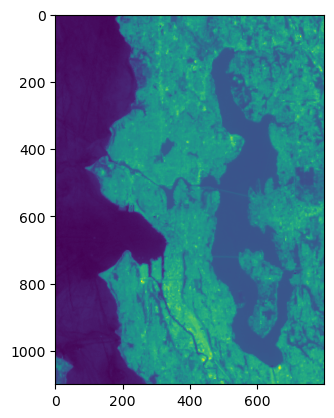

In [ ]:
f, ax = plt.subplots()
plt.imshow(chunk, interpolation='none')

### Store a reduced resolution view (1 pixel for every 100 original pixels)

In [ ]:
asub = a_st[::10, ::10]
asub

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0.0,
  dtype=float32)

In [ ]:
asub.shape

(790, 778)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs


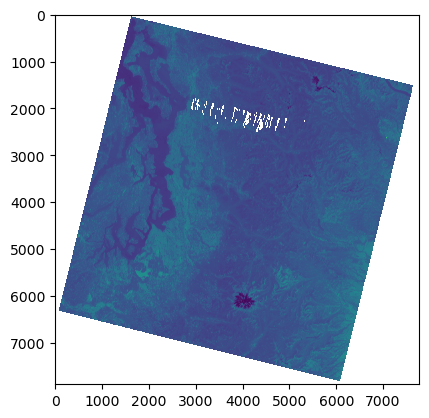

In [ ]:
%time
f, ax = plt.subplots()
plt.imshow(a_st);

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


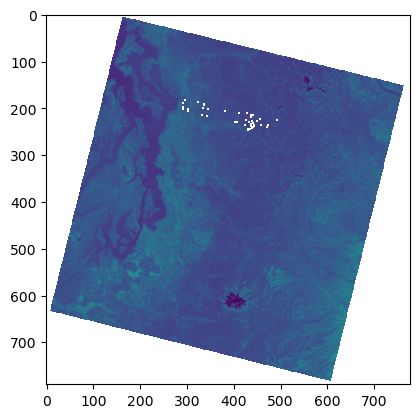

In [ ]:
#Every 10th pixel - great strategy for quick visualization during development/exploration
%time
f, ax = plt.subplots()
plt.imshow(asub);

### Reading in reduced resolution overview from the start
* Since we have a cloud optimized geotiff (COG), can directly read the embedded overviews, rather than full resolution data
* Easier with rioxarray (later)

In [ ]:
ovr_level = 8 #power of 2 (see gdalinfo above for overview dimensions)
ovr_shape = (int(src.height/ovr_level), int(src.width/ovr_level))

In [ ]:
#Note memory usage before and after reading
%time
a_ovr = src.read(1, out_shape=ovr_shape)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


In [ ]:
t = src.transform
t

Affine(30.0, 0.0, 473685.0,
       0.0, -30.0, 5373615.0)

In [ ]:
#Should assign this to new dataset/profile for ovr (or just use rioxarray)
import affine
ovr_transform = affine.Affine(t[0]*ovr_level, t[1], t[2], t[3], t[4]*ovr_level, t[5])
ovr_transform

Affine(240.0, 0.0, 473685.0,
       0.0, -240.0, 5373615.0)

In [ ]:
a.shape

(7891, 7771)

In [ ]:
a_ovr.shape

(986, 971)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 12.2 µs


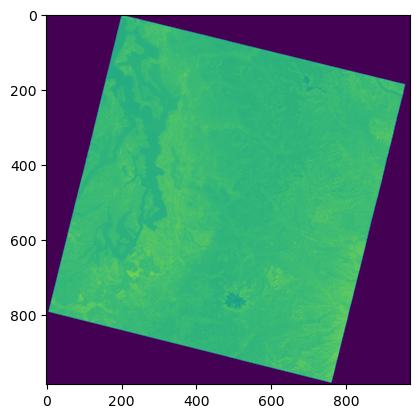

In [ ]:
%time
f, ax = plt.subplots()
plt.imshow(a_ovr);

## Raster math

In [ ]:
#%matplotlib widget

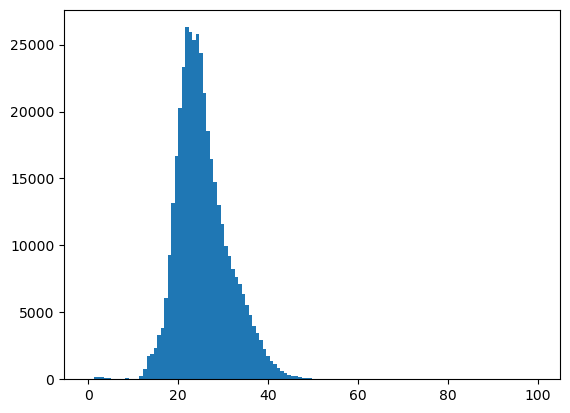

In [ ]:
#Remember to use compressed for historgrams with 2D masked arrays
f, ax = plt.subplots()
plt.hist(asub.compressed(), bins=128);

In [ ]:
t_thresh = 18 #Deg C

In [ ]:
asub

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0.0,
  dtype=float32)

In [ ]:
#Identifiy pixels with values less than some threshold
asub < t_thresh

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0.0)

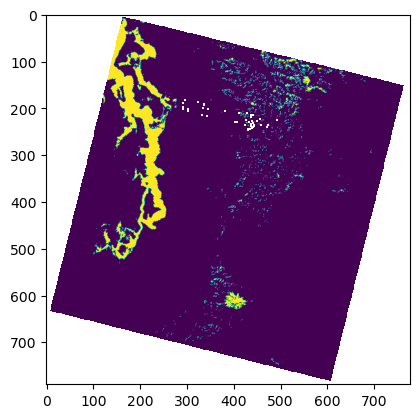

In [ ]:
f, ax = plt.subplots()
plt.imshow(asub <= t_thresh);

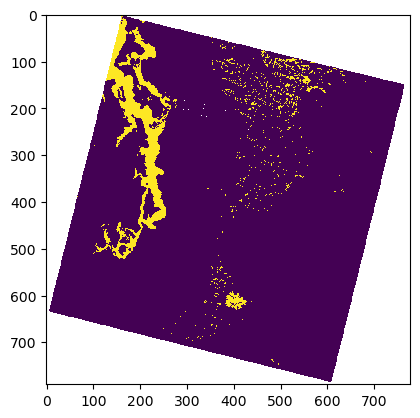

In [ ]:
#Use nearest neighbor interpolation for binary raster data!
plt.imshow(asub <= t_thresh, interpolation='none');

## Calculating area

In [ ]:
a_st.size

61320961

In [ ]:
a_st.compressed().size

40633950

In [ ]:
a_st.count()

40633950

In [ ]:
#Count up nonzero values - somewhat complicated way
(a_st <= t_thresh).nonzero()[0].size

2512952

In [ ]:
#Sum the boolean values (True = 1, False = 0)
n_px = (a_st <= t_thresh).sum()
n_px

2512952

In [ ]:
src.res

(30.0, 30.0)

In [ ]:
#Ground sample distance for a single pixel in meters
src.res

(30.0, 30.0)

In [ ]:
#Area of single pixel (m^2)
px_area = src.res[0] * src.res[1]
px_area

900.0

In [ ]:
n_px * px_area

2261656800.0

## Cleanup and memory management

In [ ]:
#Delete array from memory
a = None
a_st = None
asub = None

In [ ]:
#Close the rasterio dataset
src.close()

In [ ]:
#%reset array

## GDAL Python API basics
* I'm including this for reference
    * It's not that complicated, even though rasterio is the more popular option for Python these days (partly because of much better documentation)
* https://gdal.org/user/raster_data_model.html
* https://github.com/OSGeo/gdal/tree/master/gdal/swig/python/samples
* https://pcjericks.github.io/py-gdalogr-cookbook/index.html

In [ ]:
#Open the green band GeoTiff as GDAL Dataset object
ds = gdal.Open(tir_fn)

In [ ]:
#Get the raster band
gdal_b = ds.GetRasterBand(1)
#Read into array
a = gdal_b.ReadAsArray()

In [ ]:
#Inspect the array
a

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

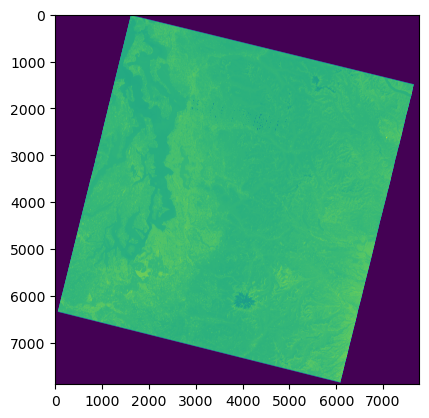

In [ ]:
#View the array
f, ax = plt.subplots()
ax.imshow(a);

In [ ]:
#Set array to None (frees up RAM) and close GDAL dataset
a = None
ds = None